# Stacking

Training D1_D2 dataset using the `Stacking` ensemble method.

### Author
Ajinkya Indulkar

In [1]:
# import libraries
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# base learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ensemble learning - stacking
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

# import visualization library
from matplotlib import pyplot as plt
import seaborn as sns


# set seed (for reproducibility)
np.random.seed(43)

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

### Data Loading + Pre-processing

In [2]:
# initialize class
tp = Tadpole(debug=True)

In [3]:
# load and pre-process tadpole dataset
tp.load()
print("Labels:", tp.label_dict)

loading tadpole dataset
pre-processing dataset
Labels: {0: 'AD', 1: 'CN', 2: 'MCI'}


In [4]:
# train-test split
tp.split()

splitting dataset to train and test datasets


In [5]:
# import variables from class instance (notebook compatibility)
label_dict = tp.label_dict
X, y, X_train, X_test, y_train, y_test = tp.X, tp.y, tp.X_train, tp.X_test, tp.y_train, tp.y_test

Helper Functions

In [6]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='GnBu')
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Test Data Confusion Matrix')
    plt.show()
    
def computeMetrics(model, X, y):
    """
    @description:
        function to compute performance metrics
    @arguments:
        model (sklearn) - trained model
        X (np.array) - features
        y (np.array) - target
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovr", average="macro")
    return BCA, mAUC

def report(model):
    """
    @description:
        function to report trained model performance
    @arguments:
        model (sklearn) - trained model
    """
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    BCA_train, mAUC_train = computeMetrics(model, X_train, y_train)
    BCA_test, mAUC_test = computeMetrics(model, X_test, y_test)
    print("========Model Evaluation Report========")
    print("Train Score: ", score_train)
    print("Test Score: ", score_test)
    print("=======================================")
    print("Train BCA: {:.3f} | Train AUC: {:.3f}".format(BCA_train, mAUC_train))
    print("Test BCA: {:.3f} | Test AUC: {:.3f}".format(BCA_test, mAUC_test))
    print("=======================================")
    showConfusionMatrix(model, X_test, y_test)
    return [score_train, score_test, BCA_train, BCA_test, mAUC_train, mAUC_test]

def evaluate(baselearners):
    """
    @description:
        function to evaluate base learners
    @arguments:
        baselearners (sklearn) - list of trained models
    """
    metrics = []
    for name, model in baselearners.items():
        print(name)
        results = report(model)
        metrics.append([name] + results)
    return metrics

### Base Learners: Model Training

#### Logistic Regression (LRA)

In [7]:
# define and train
lra = LogisticRegression(verbose=2)
lra.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=2,
                   warm_start=False)

#### Decision Trees (DT)

In [8]:
# define and train
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Multi-layer Perceptron (ANN)

In [9]:
# define and train
mlp = MLPClassifier(verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.04343984
Iteration 2, loss = 0.96830007
Iteration 3, loss = 0.93961552
Iteration 4, loss = 0.91601785
Iteration 5, loss = 0.88987019
Iteration 6, loss = 0.86543592
Iteration 7, loss = 0.84266143
Iteration 8, loss = 0.81907261
Iteration 9, loss = 0.79639521
Iteration 10, loss = 0.77425045
Iteration 11, loss = 0.75428291
Iteration 12, loss = 0.73587144
Iteration 13, loss = 0.71768414
Iteration 14, loss = 0.70183236
Iteration 15, loss = 0.68743419
Iteration 16, loss = 0.67292295
Iteration 17, loss = 0.66004032
Iteration 18, loss = 0.64816440
Iteration 19, loss = 0.63712069
Iteration 20, loss = 0.62748023
Iteration 21, loss = 0.61785933
Iteration 22, loss = 0.60893433
Iteration 23, loss = 0.60053832
Iteration 24, loss = 0.59262433
Iteration 25, loss = 0.58453479
Iteration 26, loss = 0.57887297
Iteration 27, loss = 0.57060920
Iteration 28, loss = 0.56393366
Iteration 29, loss = 0.55726622
Iteration 30, loss = 0.55129272
Iteration 31, loss = 0.54518932
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

#### SVM

In [10]:
# define and train
svm = SVC(verbose=True, probability=True)
svm.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

#### Evaluate Base Learners

In [11]:
# define dictionary of all baselearners
baselearners = {'LRA': lra, 'DT': dtc, 'ANN': mlp, 'SVM': svm}

LRA
========Model Evaluation Report========
Train Score:  0.8302023121387283
Test Score:  0.861271676300578
Train BCA: 0.802 | Train AUC: 0.951
Test BCA: 0.825 | Test AUC: 0.962


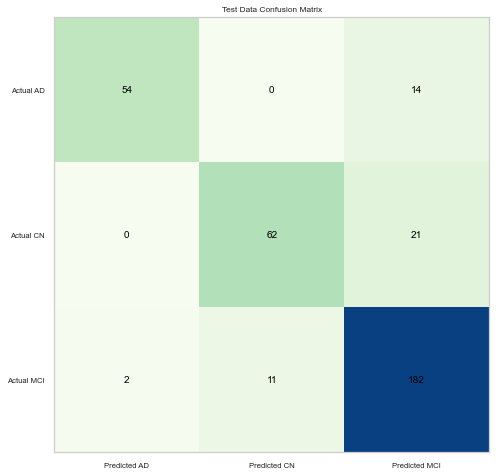

DT
========Model Evaluation Report========
Train Score:  1.0
Test Score:  0.8352601156069365
Train BCA: 1.000 | Train AUC: 1.000
Test BCA: 0.820 | Test AUC: 0.860


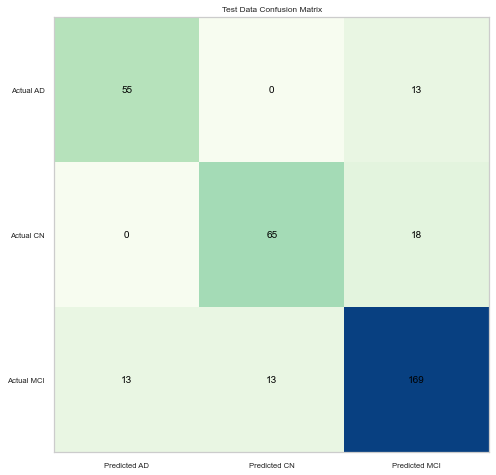

ANN
========Model Evaluation Report========
Train Score:  0.875
Test Score:  0.9046242774566474
Train BCA: 0.871 | Train AUC: 0.968
Test BCA: 0.897 | Test AUC: 0.972


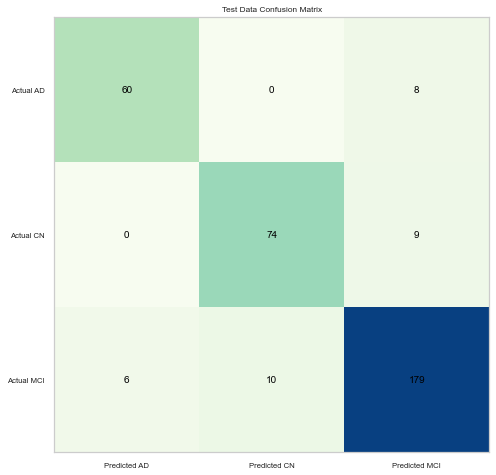

SVM
========Model Evaluation Report========
Train Score:  0.8735549132947977
Test Score:  0.8872832369942196
Train BCA: 0.874 | Train AUC: 0.969
Test BCA: 0.888 | Test AUC: 0.965


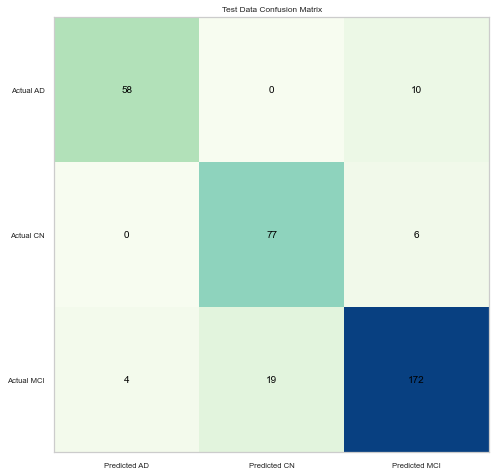

In [12]:
# evaluate
metrics = evaluate(baselearners)

### Stacking - Ensemble Learning: Model Training

Level 1 Classifiers - LRA, DT, ANN and SVM

Level 2 Classifier - LRA

In [13]:
# define level 1 estimators
estimators = [
    ('lra', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('ann', MLPClassifier()),
    ('svm', SVC(probability=True))
]

In [14]:
# define and train stacking ensemble method
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=2)
stk_clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


StackingClassifier(cv=None,
                   estimators=[('lra',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('dt',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                               

========Model Evaluation Report========
Train Score:  0.9002890173410405
Test Score:  0.9046242774566474
Train BCA: 0.891 | Train AUC: 0.983
Test BCA: 0.894 | Test AUC: 0.971


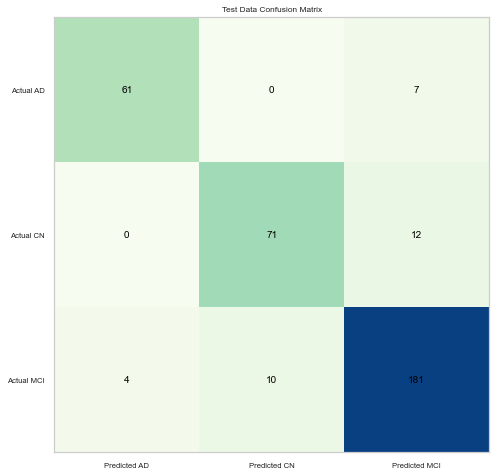

In [15]:
el_metrics = report(stk_clf)

### Save Best Model

In [16]:
model_name = "stacking_030620_1.pkl" #ensemble-date-modelversion

tp.save(stk_clf, model_name)

saving trained model


### Visualize Results

In [17]:
# add stacking results
metrics.append(['stacking'] + el_metrics)
# create results dataframe
results_df = pd.DataFrame(metrics, columns=['classifier', 'score_train', 'score_test', 'BCA_train', 'BCA_test', 
                                            'mAUC_train', 'mAUC_test'])

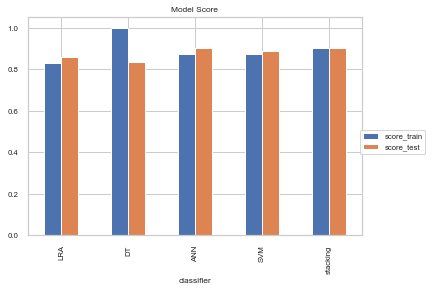

In [18]:
results_df.plot(x='classifier', y=['score_train', 'score_test'], kind='bar', 
                title='Model Score', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

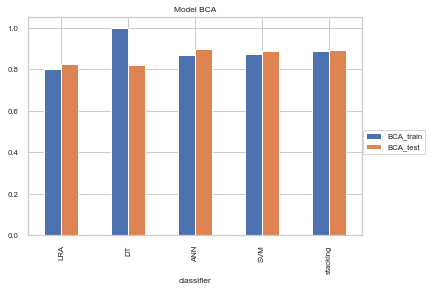

In [19]:
results_df.plot(x='classifier', y=['BCA_train', 'BCA_test'], kind='bar', 
                title='Model BCA', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

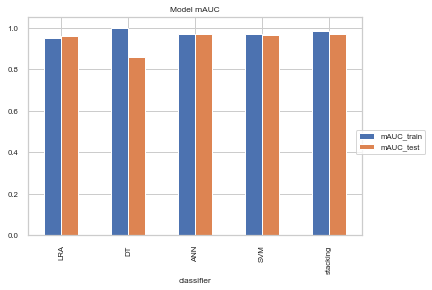

In [20]:
results_df.plot(x='classifier', y=['mAUC_train', 'mAUC_test'], kind='bar', 
                title='Model mAUC', grid=True).legend(bbox_to_anchor=(1.2, 0.5));